In [160]:
#Advanced Lane Finding project

#Needed packages

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from collections import deque
import os, sys

%matplotlib inline

# Part 1 - Camera calibration

In [161]:
# prepare object points
nx = 9 #the number of inside corners in x
ny = 6 #the number of inside corners in y

# prepare the empty vectors
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# load the calibration images
images = glob.glob('camera_cal/calibration*.jpg')


then the code to execute the calibration

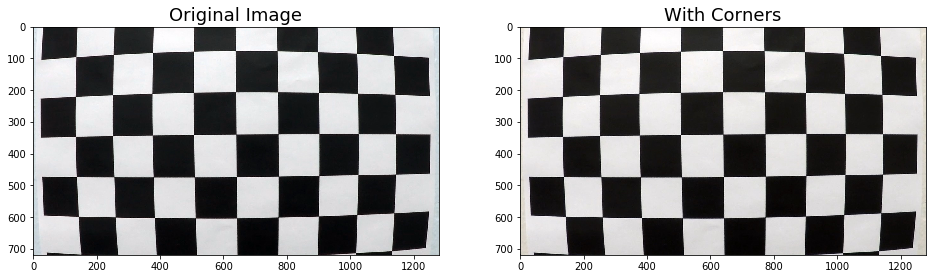

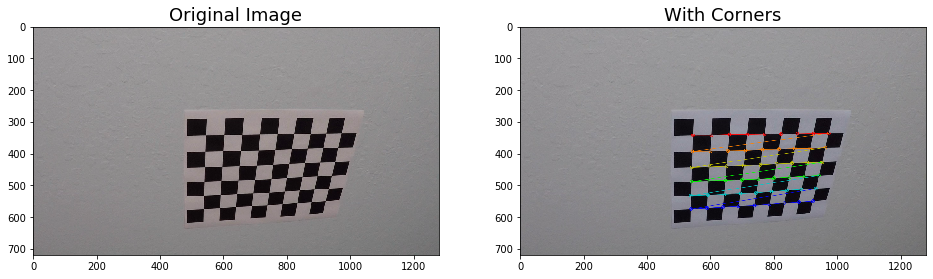

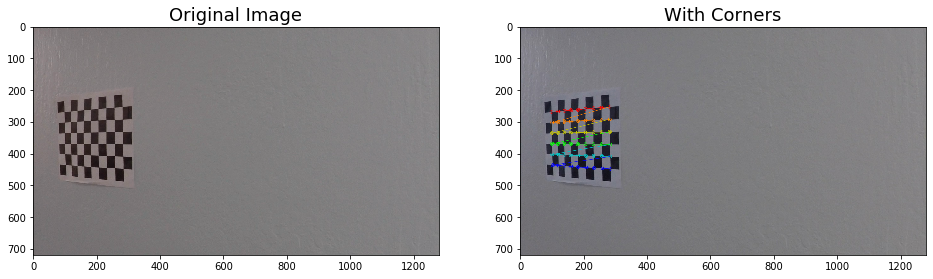

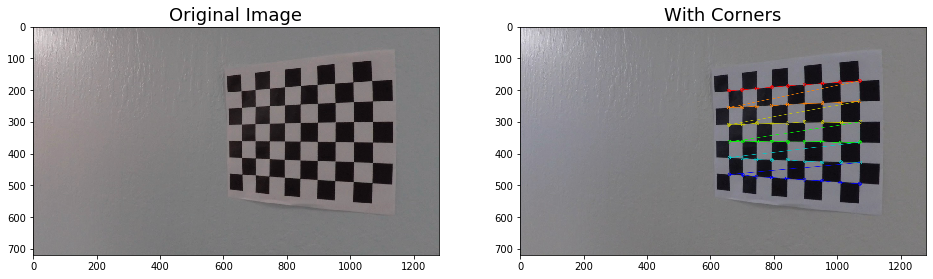

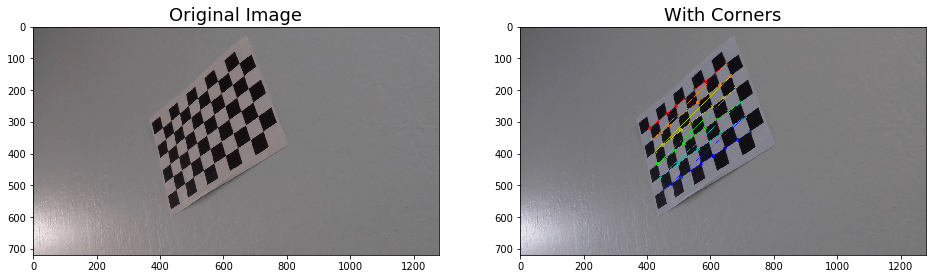

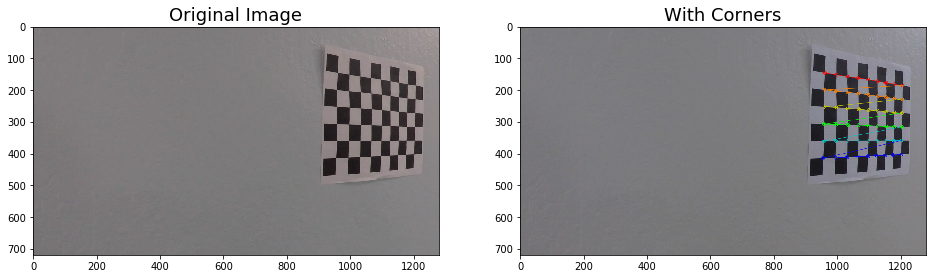

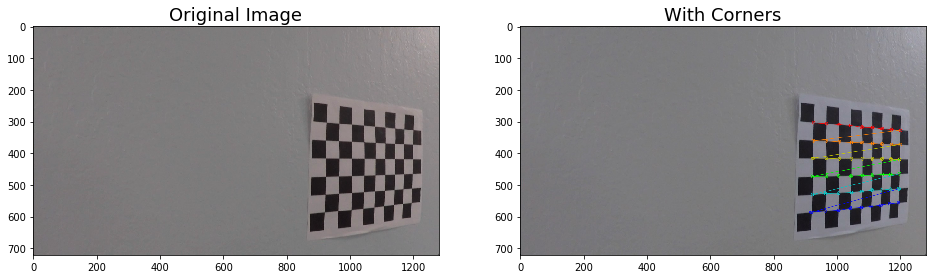

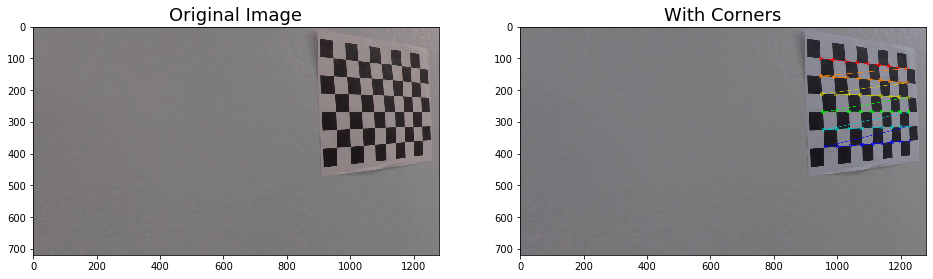

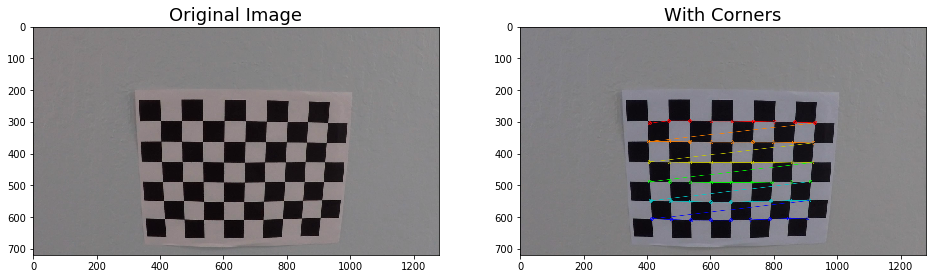

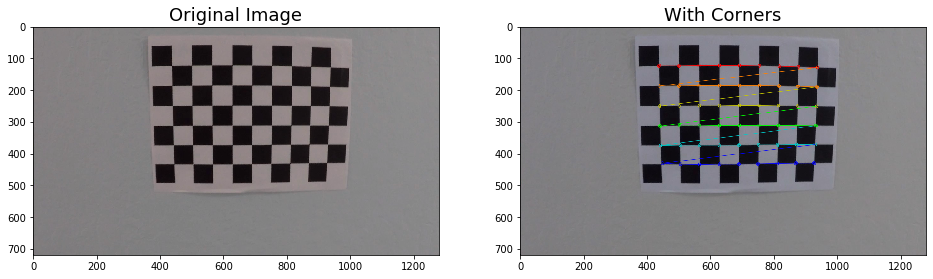

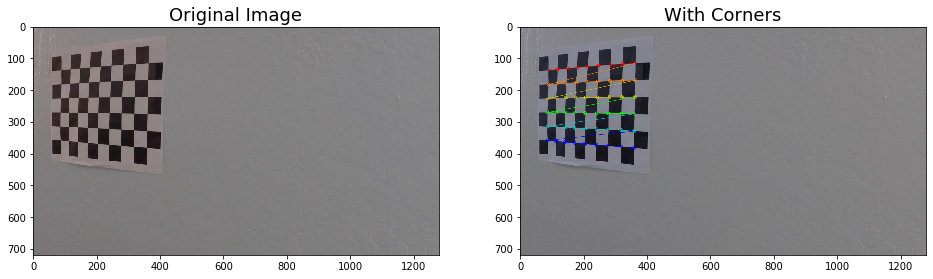

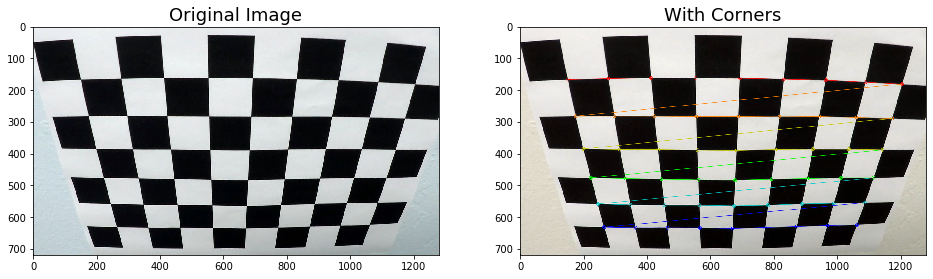

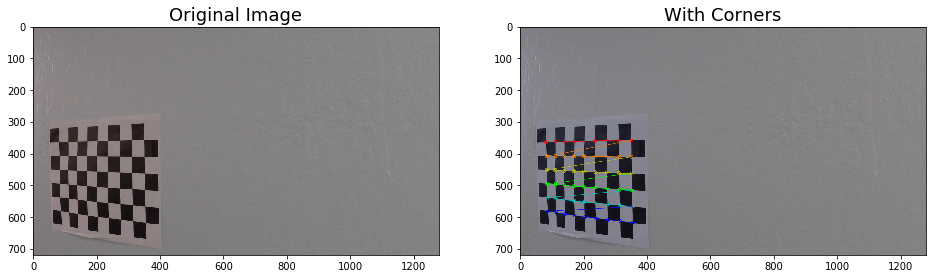

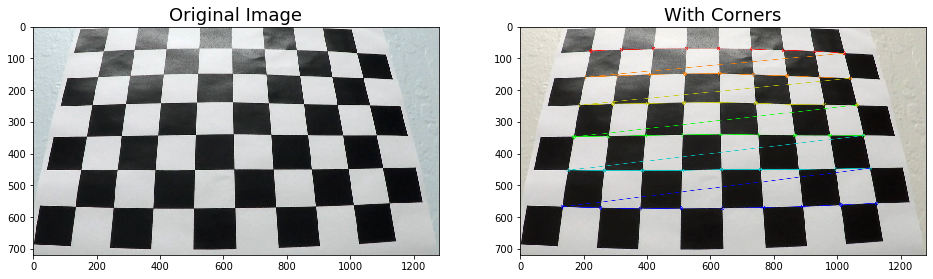

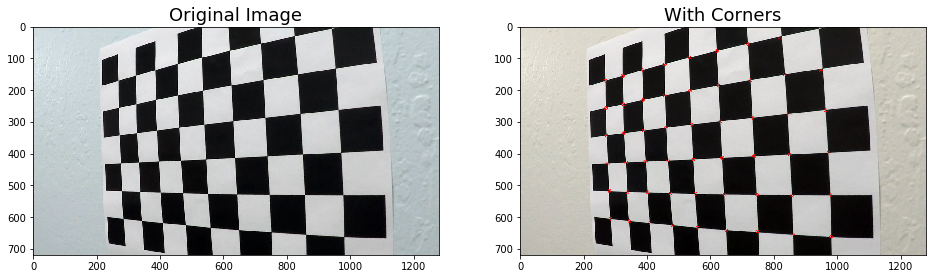

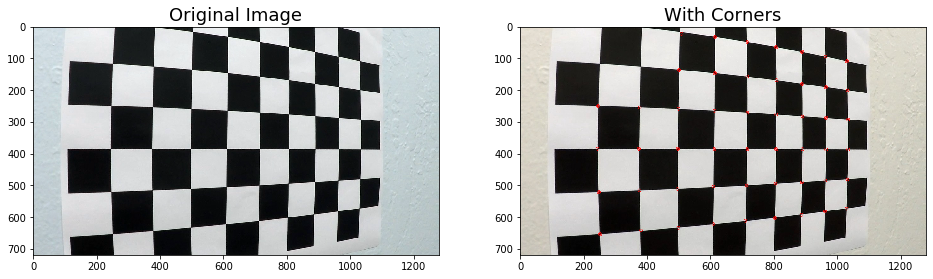

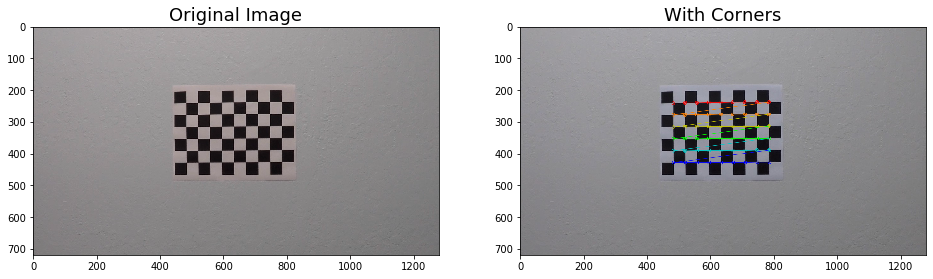

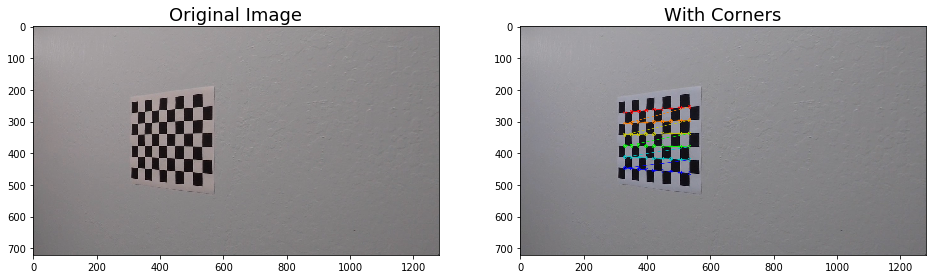

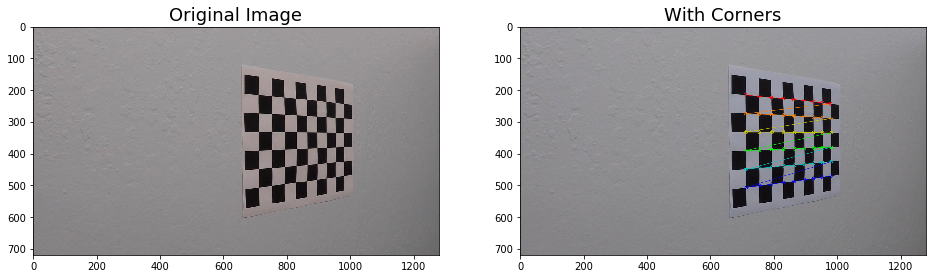

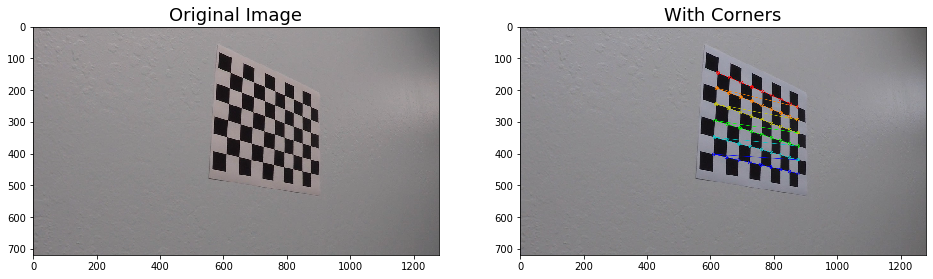

In [169]:
# for each image, execute the following
for idx, fname in enumerate(images):
    
    #load images
    img = cv2.imread(fname)
    
    #convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=18)
    ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax2.set_title('With Corners', fontsize=18)    


# Here is title
hello world

In [ ]:
images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    
    #load images
    img = cv2.imread(fname)

    # Undistort the image by using the above filled vectors
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite("output_images/"+fname)
    
    # Draw and display the final undistorted images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted Image', fontsize=20)

# Part 2 - Apply it to the road

In [154]:
# Remove distortion from images
def undistort(image, show=False):
    
    img = cv2.imread(image)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
   
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=20)
    else:
        return undist
    
# Perform perspective transform
def warped(img, display=False):

    undist = undistort(img, show = True)

    img_size = (undist.shape[1], undist.shape[0])
    
    offset = 0
    
    top_right =    [490,482]
    top_left =     [810,482]
    bottom_right = [1250,720]
    bottom_left=   [40,720]
    
    top_right_dst =    [0,0]
    top_left_dst =     [1280,0]
    bottom_right_dst = [1250,720]
    bottom_left_dst=   [40,720]

    
    src = np.float32([[top_right],[top_left],[bottom_right],[bottom_left]])
    dst = np.float32([[top_right_dst],[top_left_dst],[bottom_right_dst],[bottom_left_dst]])
    
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    M_inv = cv2.getPerspectiveTransform(dst, src) 
    
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted and Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    else:
        return warped, M, M_inv
        
        
#Calculate different gradients    
def gradients(img, display=True):

    warped = cv2.imread(warped(img, display=False))
    #Calculate Sobel x and y
    #transform in gray scale
    gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)

    #aplying CV2 Sobel
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

    #Take the absolute value of the output from cv2.Sobel()
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    #calculate the magnitude gradient
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255

    # Scale the result to an 8-bit range (0-255)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    gradmag = (gradmag/scale_factor).astype(np.uint8)

    # Apply lower and upper thresholds
    thresh_min = 20
    thresh_max = 100

    # Create binary_outputs
    sxbinary = np.zeros_like(scaled_sobelx)
    sybinary = np.zeros_like(scaled_sobely)
    gradmagbinary = np.zeros_like(gradmag)

    sxbinary[(scaled_sobelx >= thresh_min) & (scaled_sobelx <= thresh_max)] = 1
    sybinary[(scaled_sobely >= thresh_min) & (scaled_sobely <= thresh_max)] = 1
    gradmagbinary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return sxbinary, sybinary, gradmagbinary

AttributeError: 'NoneType' object has no attribute 'shape'

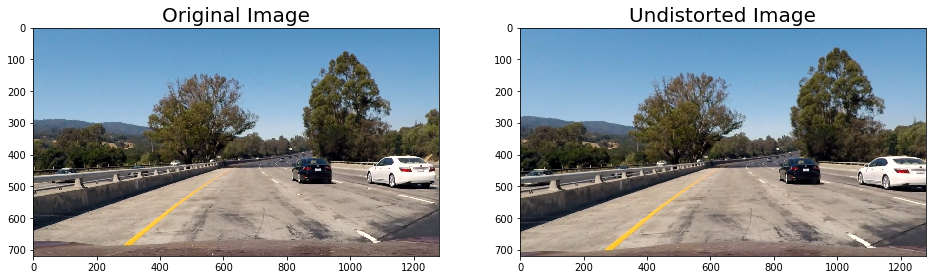

In [159]:
#images = glob.glob('test_images/*.jpg')

#for fname in enumerate(images):
    
#    print(images)
    
    #load images
    #img = cv2.imread(fname)
    #undistort(img)
    #cv2.imwrite("output_images/undist_"+file, undist)
    #warped(undist)
    #cv2.imwrite("output_images/warped_"+file, warped)

images = glob.glob('test_images/test*.jpg')
for image in images:
    undistort(image)
    warped(image)
    cv2.imwrite("output_images/warped_"+fname, warped)
    
    

<function warped at 0x0000020E212F39D8>


# Now gradient

UnboundLocalError: local variable 'warped' referenced before assignment

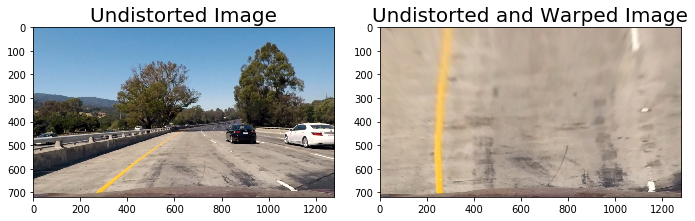

In [98]:
images = glob.glob('test_images/test*.jpg')
for image in images:
    undistort(image)
    warped(image)
    gradients(image)
    
    f, (x1, x2, x3) = plt.subplots(1, 3, figsize=(24, 9))
    x1.axis('off')
    x1.imshow(image)
    x1.set_title('Original', fontsize=20)

    x2.axis('off')
    x2.imshow(edges)
    x2.set_title('Warped', fontsize=20)
    
    x3.axis('off')
    x3.imshow(stack)
    x3.set_title('gradients', fontsize=20)